# Sky localization ellipses for a fixed sky grid

### Setup and imports

Import the relevant codes, set the plotting style

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt

from simple_pe.localization import loc, event
from simple_pe.detectors import detectors, network
import lal

import cartopy.crs as ccrs


In [2]:
'''For plotting the L shaped interferometer marker have to manually draw them as in this cell:
'''
from matplotlib.path import Path

verts = [
    (0., 1.), # left, top
    (0., 0.), # left, bottom
    (1., 0.), # right, bottom
    ]
codes = [Path.MOVETO,
         Path.LINETO,
         Path.LINETO,
         ]
path = Path(verts, codes)

## Network and parameter details

Set the parameters

In [3]:
net_state=["design"]

method = 'time' 
found_thresh = 5.0
net_thresh = 12.0
loc_thresh = 4.0
duty_cycle = 1.0

BNS_min_chirp_mass = 1.4 * 2**(-1./5)

In [4]:
savefig = True
savetxt = False

## Run a set of fake events, fixed distance, face on

In [5]:
# set up trials
dra, ddec = np.pi/8.0, np.pi/16.0
[ra,dec] = np.mgrid[-np.pi+ dra:np.pi:dra,-np.pi/2 + ddec:np.pi/2:ddec]

ra = ra.flatten()
dec = dec.flatten()
Dco = 200.#830# #1916. -->  Comoving distence for z = 0.5 we used 2000
psi = 0.
cosi = 1.


### Take care with time
Everything is calculated using ra and dec, but correcting for the Earth's rotation using the sidereal time, we need to do that for the localization as well.

In [6]:
gps_time = 999995380
gps = lal.LIGOTimeGPS(gps_time,0)
gmst = lal.GreenwichMeanSiderealTime(gps)

ntrials = len(ra)

In [7]:
params = {}
params['distance'] = Dco
params['gps'] = gps_time
params['coa-phase'] = 0.
params['polarization'] = psi
params['inclination'] = np.arccos(cosi)
params['mass1'] = 1.4
params['mass2'] = 1.4
params['RAdeg'] = 0.
params['DEdeg'] = 0.

In [8]:
## change below to similar as next cell.
num_found, num_loc, all_lists = {}, {}, {}
Ms={}
for net in net_state:
    n = network.Network()
    n.set_configuration(net, found_thresh, loc_thresh, duty_cycle)

    nf, nl = 0, 0
    all_list = []
    for trial in range(len(ra)):
        params['RAdeg'] = np.degrees(ra[trial])
        params['DEdeg'] = np.degrees(dec[trial])
        x = event.Event.from_params(params=params)
        # n.set_event_config(x)
        x.add_network(n)
        all_list.append(x)
        if x.detected:
            nf += 1
            if x.localized >= 3:
                nl += 1
                x.localize_all()
    
    # store in network dictionaries
    all_lists[net] = all_list
    num_found[net] = nf
    num_loc[net] = nl
    
    #check all were localized
    print('%s events were not localized by %s' % (ntrials - num_loc[net], net) )

/mnt/c/Users/spxsf2/Code/simple-pe/simple_pe/localization/loc.py:17: RuntimeWarning: invalid value encountered in sqrt
  sigma = 1 / np.sqrt(ev + epsilon)
/mnt/c/Users/spxsf2/Code/simple-pe/simple_pe/localization/loc.py:194: RuntimeWarning: divide by zero encountered in double_scalars
  self.like += np.log(32. * (self.D / d_max) ** 3 * self.D ** 4 / (Fp ** 2 * Fc ** 2)


50 events were not localized by design


Extract details of detected events, number of sky patches.

In [9]:
method = 'time'
Ps={}
detects={}
for net in net_state:
    patches=[]
    detect=[]
    for ev in all_lists[net]:
        detect.append(ev.detected)
        try: patches.append(ev.patches[method])
        except: KeyError
    detects[net] = detect
    Ps[net] = np.array(patches)
    print("%s: Fraction localized to one patch = %.3f" % 
          (net, (1. * sum(Ps[net] == 1)/len(patches))) )

design: Fraction localized to one patch = 0.000


Get the localization matrix for each point

## Plot the localization ellipses

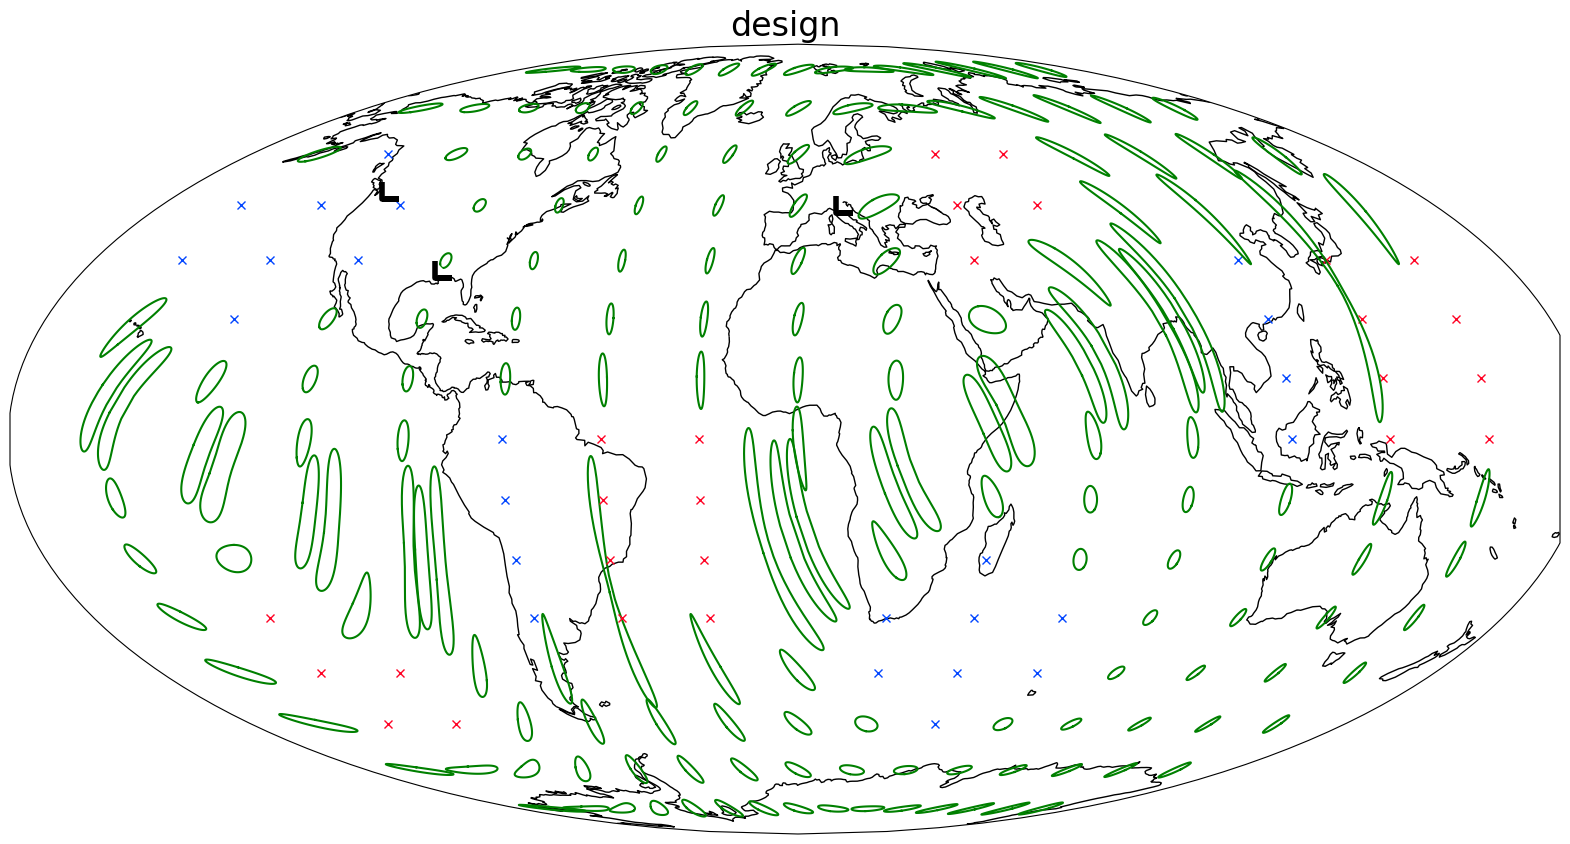

In [10]:
for net in net_state:
    plt.figure(figsize=[20,20])
    ax = plt.axes(projection=ccrs.Mollweide())
    data_crs = ccrs.PlateCarree()
    ax.coastlines()

    for i, ev in enumerate(all_lists[net]):
        if not ev.detected:
            ra = (ev.ra - gmst) % (2*np.pi)
            ax.plot(np.degrees(ev.ra - gmst), np.degrees(ev.dec) ,'#ff0325', marker = 'x', 
                    markersize=6, markeredgewidth=1, transform=data_crs)
        elif ev.localized < 3:
            ra = (ev.ra - gmst) % (2*np.pi)
            ax.plot(np.degrees(ev.ra - gmst), np.degrees(ev.dec) ,'#0346ff', marker = 'x', 
                    markersize=6, markeredgewidth=1, transform=data_crs)
        else:
            phi, theta = ev.localization['time'].make_ellipse()
            ax.plot(np.degrees((phi - np.pi) % (2 * np.pi) + np.pi), np.degrees(theta), 'g', transform=data_crs)

    for ifo in ev.ifos:
        i = ev.__getattribute__(ifo)
        phi, theta = detectors.phitheta(i.location/np.linalg.norm(i.location))
        ax.plot(np.degrees(phi), np.degrees(theta), marker=path, markersize=25, 
                markerfacecolor='w', markeredgecolor='k', markeredgewidth=4, 
                transform=data_crs)

    plt.title(net, fontsize = 24)
